# Proyecto Final: Online Retail Analysis

<div class="alert alert-info", role="alert">
    <h2>🎯 </h2>
    <p>
      El objetivo de este proyecto es poner en práctica todo lo visto y aprendido durante el curso de <a href="https://platzi.com/cursos/python-data-science/">Python para Ciencia de Datos</a>, en el cuál vemos la aplicación de herramientas para el análisis de datos como son:
      <ul>
        <li>numpy</li>
        <li>pandas</li>
        <li>matplotlib</li>
      </ul>
    </p>
</div>

El objetivo principal del análisis es entender los patrones de compra, identificar los productos más vendidos y los clientes más valiosos, y detectar posibles tendencias en las ventas. 
<br>
Algunas de las preguntas a responder son:
- ¿Cuáles son los productos más vendidos?
- ¿Que productos tienen mayor tasa de devolución?
- ¿Quiénes son los clientes más valiosos?
- ¿Hay patrones estacionales o tendencias en las ventas?
- ¿Cuáles son los países con mayores ventas?

## Librerias y carga de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker  as ticker
import seaborn as sns

# Formato Moneda para aplicar en los gráficos.
money_formatter = ticker.StrMethodFormatter("${x:,.0f}")
quantity_formatter = ticker.StrMethodFormatter("{x:,.0f}")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

import modules.utils.paths as path

In [4]:
file_path = path.data_raw_dir("online_retail.csv")
retail_df = pd.read_csv(file_path)

## Exploración inicial

In [5]:
total_rows, total_cols = retail_df.shape
print(f"Filas: {total_rows} \nColumnas: {total_cols}")
retail_df.sample(3)

Filas: 541909 
Columnas: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
12231,537371,90060D,FIRE POLISHED GLASS NECKL BRONZE,1,2010-12-06 12:47:00,5.95,15028.0,United Kingdom
21812,538145,35648,VINTAGE BEAD PINK PURSE,12,2010-12-09 16:08:00,2.95,15211.0,United Kingdom
410297,572103,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,2011-10-20 15:57:00,0.85,17571.0,United Kingdom


In [6]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
duplicated_rows = retail_df.duplicated().sum()
duplicated_proportion = round(duplicated_rows/len(retail_df) * 100, 2)
print(f"Registros duplicados: {duplicated_rows} \nProporción: {duplicated_proportion}")

Registros duplicados: 5268 
Proporción: 0.97


In [9]:
missing_values = retail_df.isna().sum().sum()
missing_proportion = round(missing_values/len(retail_df) * 100, 2)
print(f"Valores faltantes: {missing_values} \nProporción: {missing_proportion}")

Valores faltantes: 136534 
Proporción: 25.2


**Observaciones**
- El Dataset cuenta con 541,909 registros y 8 columnas (características).
- Tenemos 3 tipos de datos: `float64`, `int64` y `object`.
- La columna `InvoiceDate` que representa la **fecha** de compra tiene un tipo de dato incorrecto (`object`).
- El $0.97\%$ de los registros estan duplicados.
- El $25.2\%$ de los registros son valores faltantes.

## Limpieza

### Duplicados y valores faltantes 

In [10]:
retail_cleaned = retail_df.drop_duplicates()
print(f"Duplicados: {retail_cleaned.duplicated().sum()}")

Duplicados: 0


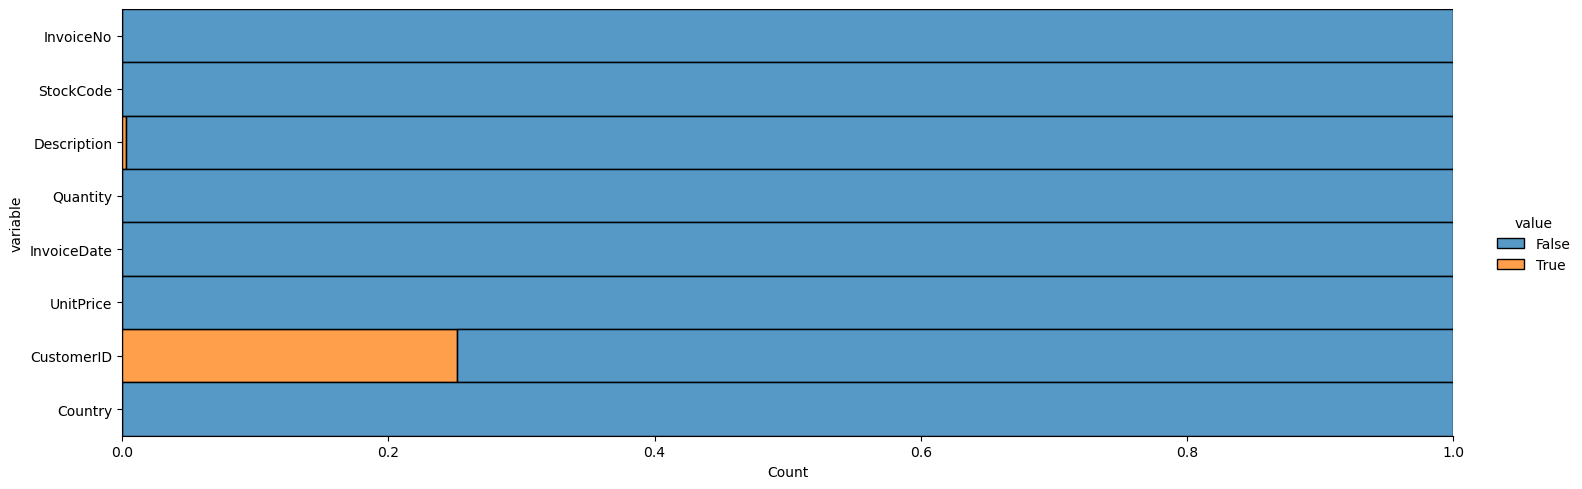

In [11]:
(
  retail_cleaned
  .isna()
  .melt()
  .pipe(
    lambda df: (
      sns.displot(
        data=df,
        y="variable",
        hue="value",
        multiple= "fill",
        aspect=3
      )
    )
  )
)
plt.show()

In [12]:
total_rows = retail_df.shape[0]
na_variables = retail_df.isna().sum()
na_variables = na_variables[na_variables > 0]
na_variables_proportion = na_variables / total_rows * 100

print("Total de valores faltantes:\n", na_variables)
print("-"*35)
print("Proporción de valores faltantes:\n", na_variables_proportion)

Total de valores faltantes:
 Description      1454
CustomerID     135080
dtype: int64
-----------------------------------
Proporción de valores faltantes:
 Description     0.268311
CustomerID     24.926694
dtype: float64


Por practicidad eliminaremos aquellos registros que tengan algún valor faltante en una de las columnas `Description` y `CustomerID`.

In [13]:
retail_cleaned = retail_cleaned.dropna(subset=["CustomerID"])
retail_cleaned.isna().sum().sum()

0

### Corrección en el tipo de dato

In [14]:
retail_cleaned["InvoiceDate"] = pd.to_datetime(retail_cleaned["InvoiceDate"])
retail_cleaned["CustomerID"] = retail_cleaned["CustomerID"].astype(int)
retail_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

## Definición de nuevas columnas

Columnas a añadir al DataFrame:
- Total Amount: Total de la compra, se obtiene de multiplicar la cantidad por el precio unitario.
- Year: Año de la compra, se extrae de la fecha de factura.
- Month: Mes de la compra, se extrae de la fecha de factura.
- Semestre: Semestre del año al que pertenece el mes, donde:
  - **1ser Semestre**: Enero a Junio
  - **2do Semestre**: Julio a Diciembre
- Quaerter: Trimestre del año al que pertenece el mes, donde:
  - **1er Trimestre**: Enero, Febrero y Marzo:
  - **2do Trimestre**: Abril, Mayo y Junio
  - **3er Trimestre**: Julio, Agosto y Semptiembre
  - **4to Trimestre**: Octubre, Noviembre y Diciembre
- Return: Indica si la factura corresponde a una devolución.

In [15]:
# Dates info
retail_cleaned["TotalAmount"] = retail_cleaned["Quantity"] * retail_cleaned["UnitPrice"]
retail_cleaned["Year"] = retail_cleaned["InvoiceDate"].dt.year
retail_cleaned["Month"] = retail_cleaned["InvoiceDate"].dt.to_period("M")

# Sales info
retail_cleaned["Return"] = retail_cleaned["Quantity"] < 0

In [16]:
retail_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month,Return
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,2010-12,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,2010-12,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False


In [17]:
retail_cleaned["Semester"] = retail_cleaned["InvoiceDate"].dt.year.astype(str) + "S" + np.where(retail_cleaned["InvoiceDate"].dt.quarter.gt(2), 2,1).astype(str)
retail_cleaned["Quaerter"] = retail_cleaned["InvoiceDate"].dt.to_period("Q")

In [18]:
retail_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month,Return,Semester,Quaerter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,2010-12,False,2010S2,2010Q4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False,2010S2,2010Q4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,2010-12,False,2010S2,2010Q4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False,2010S2,2010Q4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,2010-12,False,2010S2,2010Q4


**Observaciones**
- Con el valor del total de compra en una columna especifica podremos realizar operaciones y análisis con mayor eficiencia al no realizar multiples veces el mismo cálculo.
- A partir de los datos de año, mes, semestre y trimestres podremos realizar análisis mas enfocados en determinados momentos del año. 

## Análisis

Ya teninedo los datos limpios y preparados, procederemos a responder las preguntas desglozadas al inicio del notebook:
- ¿Cuáles son los productos más vendidos?
- ¿Que productos tienen mayor tasa de devolución?
- ¿Quiénes son los clientes más valiosos?
- ¿Hay patrones estacionales o tendencias en las ventas?
- ¿Cuáles son los países con mayores ventas?

### 1. ¿Cuáles son los productos más vendidos?

Ante esta pregunta, podemos discrepar entre los productos más vendidos vs los productos con mayores ingresos totales ($).

In [19]:
# 10 productos más vendidos en total:
best_sellers = retail_cleaned.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
most_incomes = retail_cleaned.groupby("Description")["TotalAmount"].sum().sort_values(ascending=False).head(10)

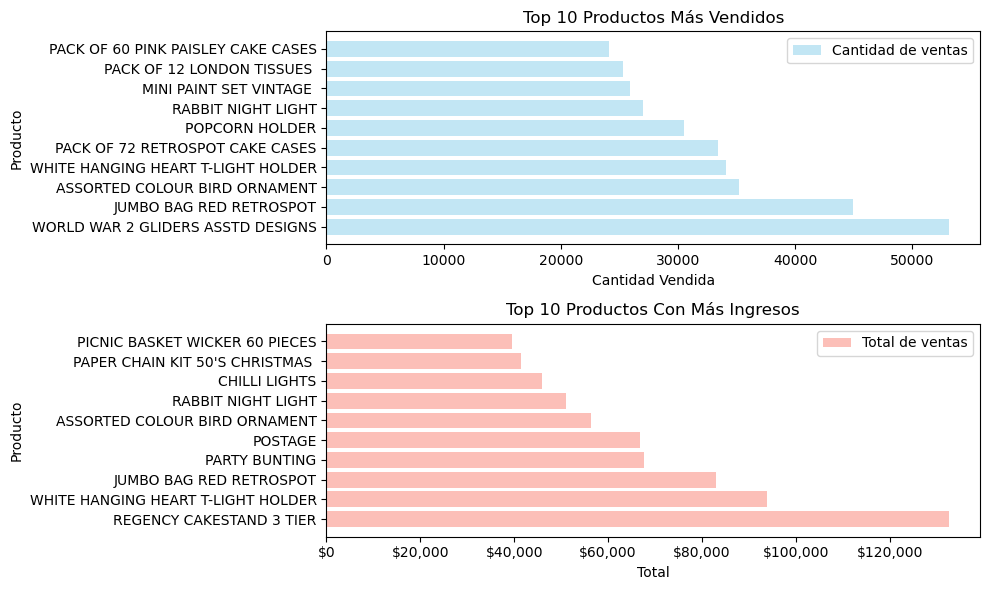

In [20]:
fig, axes =  plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].barh(
  best_sellers.index.to_list(), 
  best_sellers,
  label="Cantidad de ventas",
  color="skyblue",
  alpha=0.5
)
axes[0].legend()

axes[0].set_title("Top 10 Productos Más Vendidos")
axes[0].set_xlabel("Cantidad Vendida")
axes[0].set_ylabel("Producto")

plt.gca().xaxis.set_major_formatter(quantity_formatter)

axes[1].barh(
  most_incomes.index.to_list(), 
  most_incomes,
  label="Total de ventas",
  color="salmon",
  alpha=0.5
)
axes[1].legend()

axes[1].set_title("Top 10 Productos Con Más Ingresos")
axes[1].set_xlabel("Total")
axes[1].set_ylabel("Producto")


plt.gca().xaxis.set_major_formatter(money_formatter)

plt.tight_layout()
plt.show()

A travez del gráfico anterior, podemos observar que los productos más vendidos no necesariamente son aquellos que generan más ingresos y viceversa; partiendo de ésta premisa, surgen las siguientes preguntas:
- ¿Cuáles son aquellos productos más vendidos y que a su vez generan ingresos significativos?
- ¿Por que los productos con mayor cantidad de ventas no estan en el top 10 de productos con más ingresos generados?

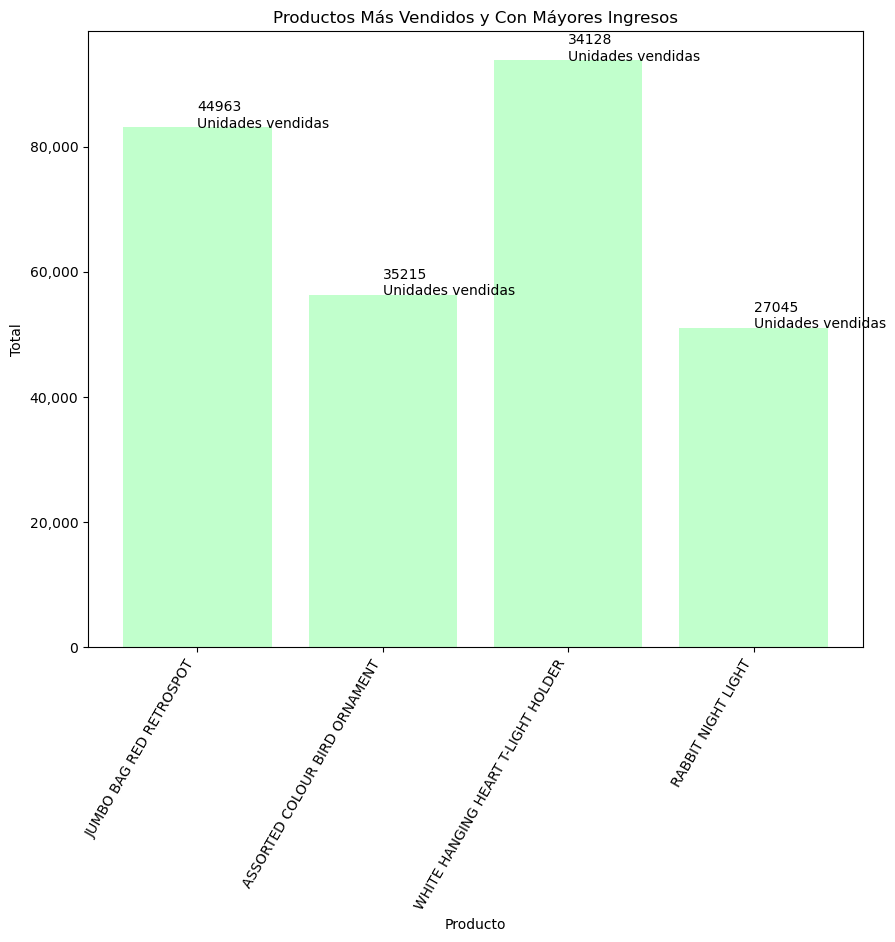

In [21]:
best_sellers_and_incomes = pd.merge(best_sellers, most_incomes, how="inner", left_index=True, right_index=True).reset_index()

plt.figure(figsize=(10,8))
plt.bar(
  best_sellers_and_incomes["Description"],
  best_sellers_and_incomes["TotalAmount"],
  color="#33FF57",
  alpha=0.3
)

plt.title("Productos Más Vendidos y Con Máyores Ingresos")
plt.xlabel("Producto")
plt.ylabel("Total")

for idx, row in best_sellers_and_incomes.iterrows():
  total_amount = row["TotalAmount"] 
  quantity = row["Quantity"]
  product_name = row["Description"]

  plt.annotate(
    f"{quantity}\nUnidades vendidas",
    xy=(product_name, total_amount+ 10)
  )


plt.gca().yaxis.set_major_formatter(quantity_formatter)
plt.xticks(rotation=60, ha="right")
plt.show()

"JUMBO BAG RED RETROSPOT" es el producto con maypr cantidad de unidades vendidas, sin embargo "WHITE HANGING HEART T-LIGHT HOLDER" es el que más ingresos a generado, al menos con el gráfico anterior podemos inferir en que "WHITE HANGING HEART T-LIGHT HOLDER" es más costoso que "JUMBO BAG RED RETROSPOT" por ello la diferencia entre estas dos métricas.

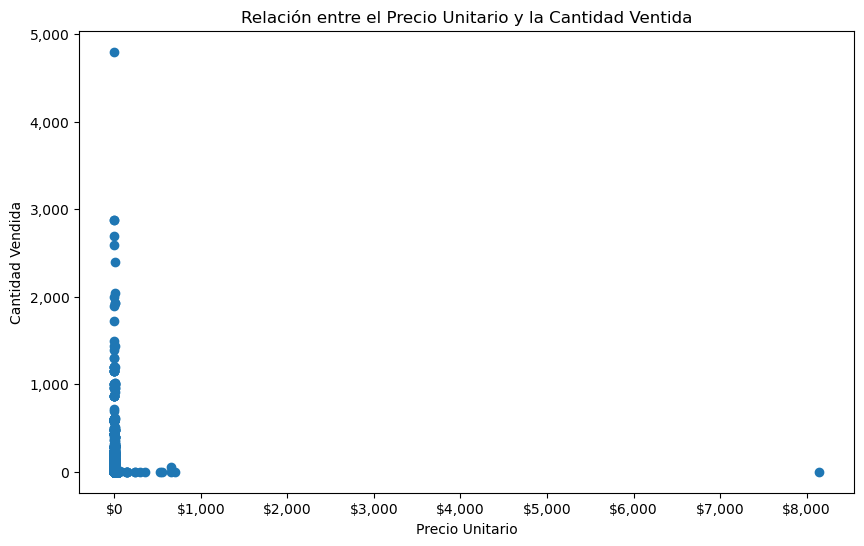

In [22]:
outer_merge = pd.merge(best_sellers, most_incomes, how="outer", left_index=True, right_index=True).reset_index()

filtered = retail_cleaned[
  (retail_cleaned["Description"].isin(outer_merge["Description"]))
  & (retail_cleaned["Quantity"] > 0)
  & (retail_cleaned["UnitPrice"] > 0)
]

plt.figure(figsize=(10,6))

plt.scatter(
  x=filtered["UnitPrice"],
  y=filtered["Quantity"],
)


plt.gca().yaxis.set_major_formatter(quantity_formatter)
plt.gca().xaxis.set_major_formatter(money_formatter)

plt.title("Relación entre el Precio Unitario y la Cantidad Ventida")
plt.xlabel("Precio Unitario")
plt.ylabel("Cantidad Vendida");

Los 10 productos más vendidos y los 10 con mayores ingresos discrepan debido a la diferencia abismal entre los precios de éstos. La venta de productos a precios bajos genera mayores ventas sobre productos con procios excecivos, especialmente cuando los productos son similares.

### 2. ¿Que productos tienen mayor tasa de devolución?

In [23]:
return_rates_data = retail_cleaned.pivot_table(
  index=["StockCode", "Description"],
  columns="Return",
  values="Quantity",
  aggfunc=(lambda x: np.abs(x).sum()),
  fill_value=0
)

return_rates_data.columns = ["Sales", "Returns"]
return_rates_data["Rate"] = return_rates_data.apply(
  lambda df: (df["Returns"]/df["Sales"] * 100) if df["Sales"] != 0 else df["Sales"],
  axis=1
)
return_rates_data = return_rates_data[return_rates_data["Rate"] > 0].sort_values(by="Rate", ascending=False).reset_index()
return_rates_data.describe()

,Sales,Returns,Rate
count,1929.000000,1929.000000,1929.000000
mean,2265.050285,140.880249,6.843561
std,4463.228225,2518.800740,24.389427
min,1.000000,1.000000,0.012516
25%,331.000000,4.000000,0.591586
50%,1023.000000,13.000000,1.612903
75%,2413.000000,37.000000,4.378284
max,80995.000000,80995.000000,700.000000


**Observación**: Existen tasas de devolución que sobrepasan el límite (100%), lo cuál puede significar que el registro de la factura de compra no entró en la fecha de corte en el inicio de extracción de los datos y por lo tanto no se incluyen en el Dataset.

In [24]:
def return_rate_classification(value):
  if value > 100:
    return "Overwhelmed"
  elif (value >= 70) & (value <= 100):
    return "Hight"
  elif (value >= 40) & (value < 70):
    return "Medium"
  else:
    return "Low"

In [25]:
return_rates_data["Class"] = return_rates_data["Rate"].apply(return_rate_classification)
return_rates_data.head()

,StockCode,Description,Sales,Returns,Rate,Class
0,20703,BLUE PADDED SOFT MOBILE,1,7,700.000000,Overwhelmed
1,22034,ROBIN CHRISTMAS CARD,3,12,400.000000,Overwhelmed
2,79323P,PINK CHERRY LIGHTS,4,8,200.000000,Overwhelmed
3,72815,3 WICK CHRISTMAS BRIAR CANDLE,2,4,200.000000,Overwhelmed
4,22769,CHALKBOARD KITCHEN ORGANISER,6,10,166.666667,Overwhelmed


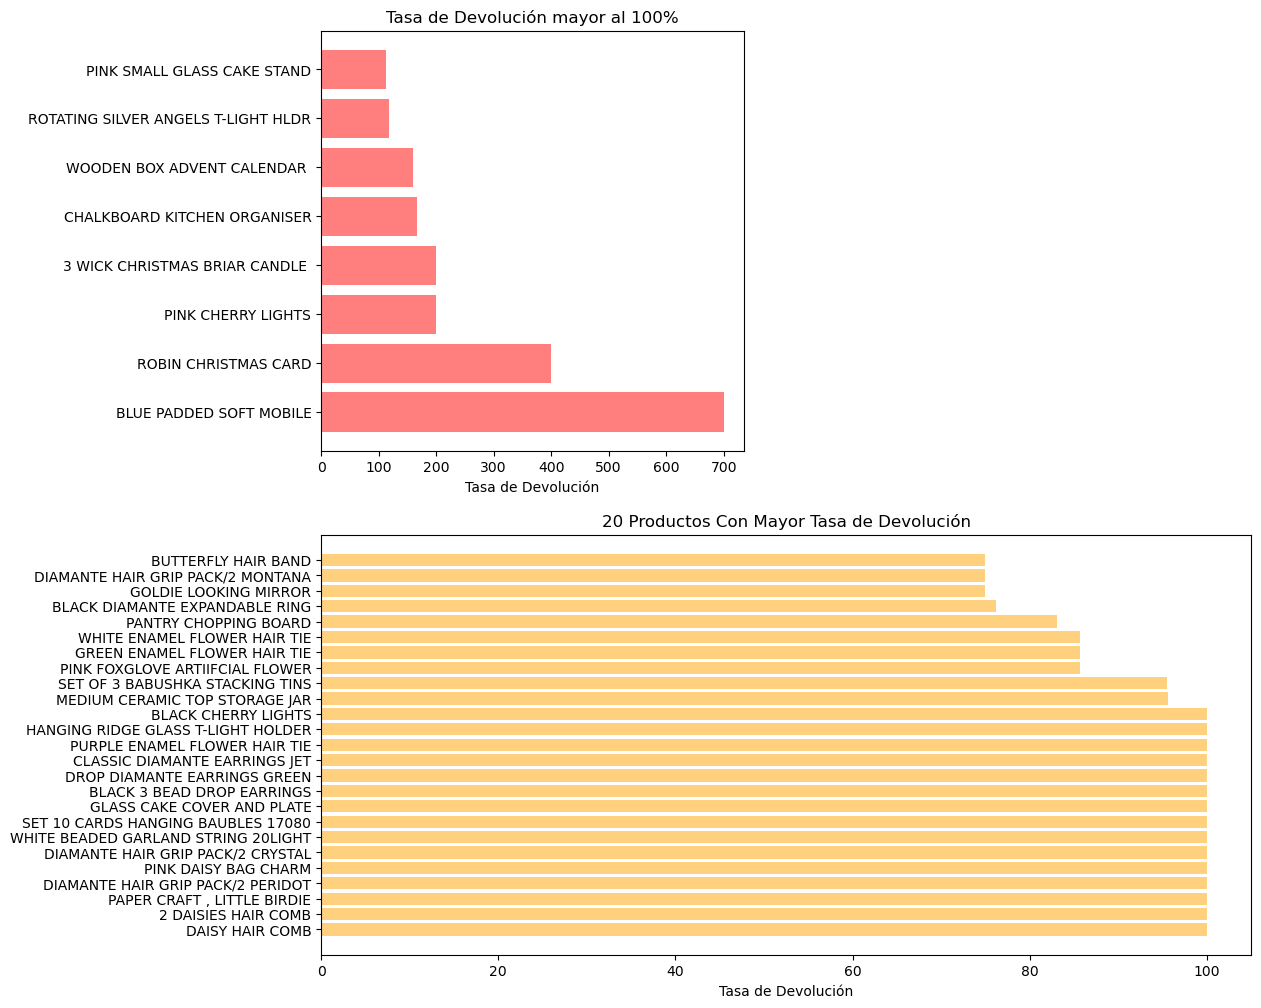

In [26]:
plt.figure(figsize=(12,12))

# Gráfico de los productos con una tasa de devolución mayor al 100%
overwhelmed_rate = return_rates_data.loc[return_rates_data["Class"] == "Overwhelmed", ["Description", "Rate"]]
top_20_hight_rr = return_rates_data.loc[return_rates_data["Class"] == "Hight", ["Description", "Rate"]][:25]

plt.subplot(2,2,1)
plt.barh(
  overwhelmed_rate["Description"],
  overwhelmed_rate["Rate"],
  color="red",
  alpha=0.5
)
plt.title("Tasa de Devolución mayor al 100%")
plt.xlabel("Tasa de Devolución")

plt.subplot(2,1,2)
plt.barh(
  top_20_hight_rr["Description"],
  top_20_hight_rr["Rate"],
  color="orange",
  alpha=0.5
)
plt.title("20 Productos Con Mayor Tasa de Devolución")
plt.xlabel("Tasa de Devolución")


plt.show()


### 3. ¿Quiénes son los clientes más valiosos?

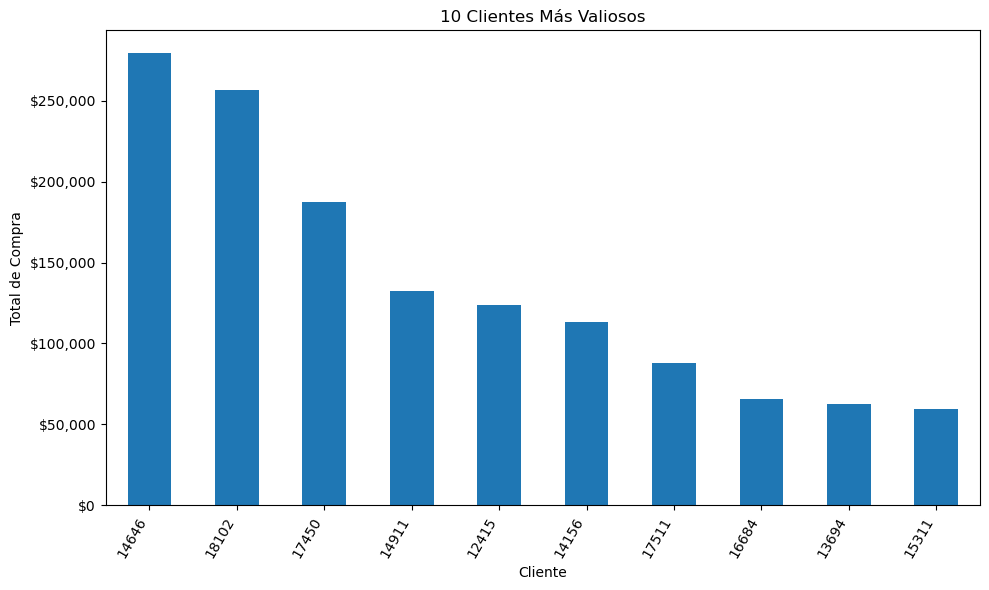

In [27]:
most_valuable_customers = retail_cleaned.groupby("CustomerID")["TotalAmount"].sum().nlargest(10).reset_index()

fig, ax = plt.subplots(figsize=(10,6))
most_valuable_customers.plot(
  kind="bar",
  x="CustomerID",
  y="TotalAmount",
  ax=ax,
  legend=""
)


plt.gca().yaxis.set_major_formatter(money_formatter)

plt.title("10 Clientes Más Valiosos")
plt.xlabel("Cliente")
plt.ylabel("Total de Compra")
plt.xticks(rotation=60, ha="right")
plt.tight_layout();


#### 3.2 ¿Qué paises tienen a los clientes con mayores compras?

In [28]:
total_customer_purchases = retail_cleaned.groupby(["Country", "CustomerID"])["TotalAmount"].sum().reset_index()
top_10_best_customer_by_country = total_customer_purchases.loc[total_customer_purchases.groupby("Country")["TotalAmount"].idxmax()].nlargest(10, "TotalAmount").reset_index()

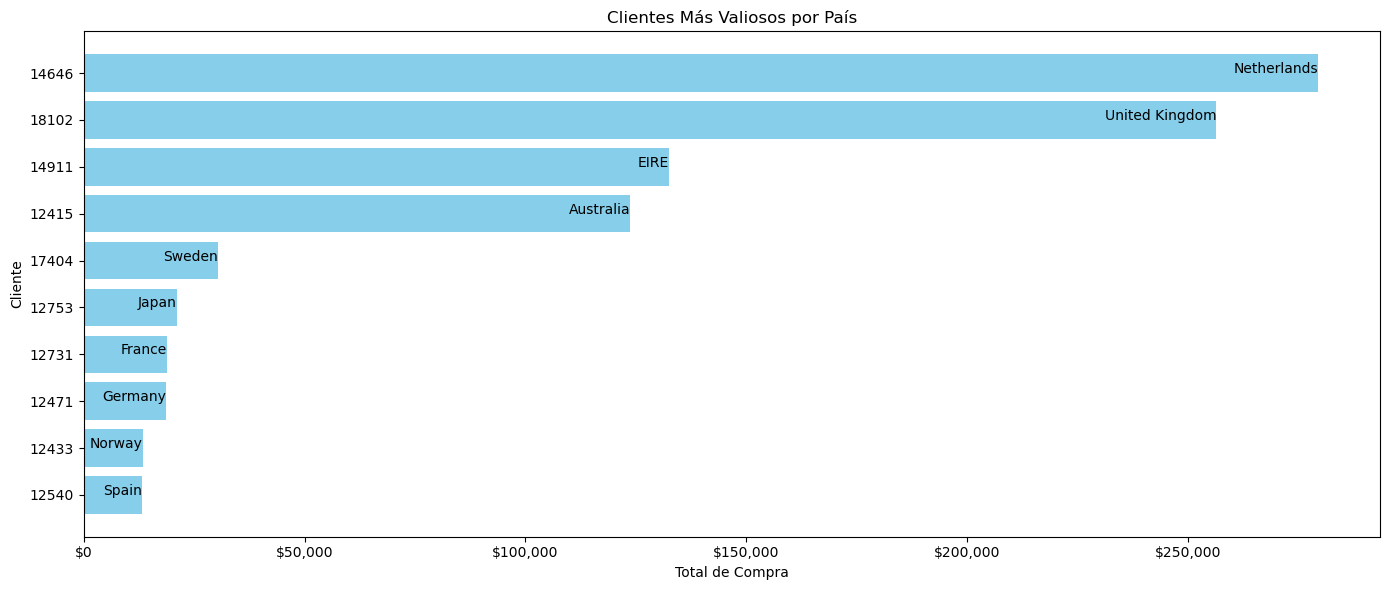

In [29]:
plt.figure(figsize=(14, 6))
plt.barh(
  top_10_best_customer_by_country["CustomerID"].astype(str),
  top_10_best_customer_by_country["TotalAmount"],
  color="skyblue"
)

max_ta =  top_10_best_customer_by_country["TotalAmount"].max()
for idx, row in top_10_best_customer_by_country.iterrows():
  plt.text(
    y=idx, 
    x=row["TotalAmount"],
    s=row["Country"], 
    ha="right"
  )


plt.gca().xaxis.set_major_formatter(money_formatter)

plt.title("Clientes Más Valiosos por País")
plt.ylabel("Cliente")
plt.xlabel("Total de Compra")
plt.tight_layout()
plt.gca().invert_yaxis();

Los clientes más destacados tanto en general como por país, son el _14646_ y _18102_, pero, ¿como ha ha sido su historial de compras a lo largo del tiempo?

In [30]:
customer_no1 = retail_cleaned[(retail_cleaned["CustomerID"] == 14646) & (retail_cleaned["TotalAmount"] > 0)]
customer_no2 = retail_cleaned[(retail_cleaned["CustomerID"] == 18102) & (retail_cleaned["TotalAmount"] > 0)]

In [31]:
c1_purches_by_date = customer_no1.groupby("InvoiceDate")["TotalAmount"].sum()
c2_purches_by_date = customer_no2.groupby("InvoiceDate")["TotalAmount"].sum()

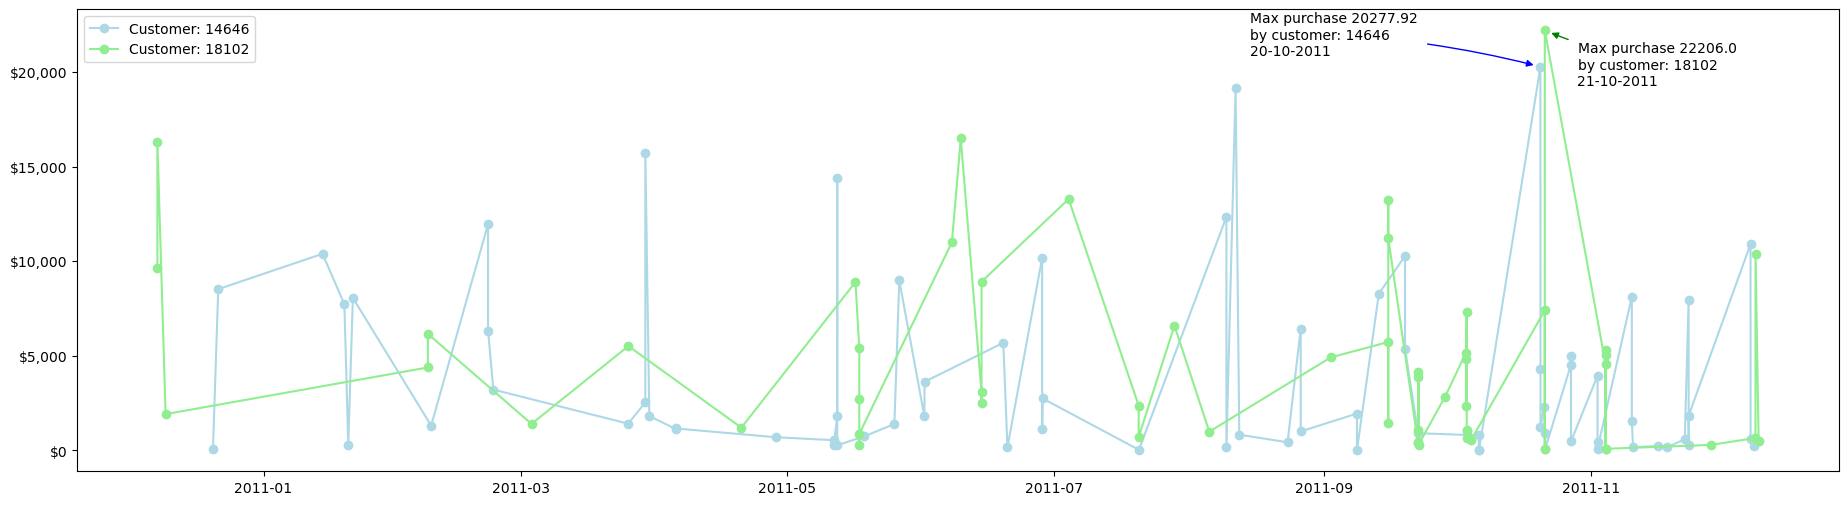

In [32]:
plt.figure(figsize=(50,6))
plt.subplot(1,2,1)


plt.plot(c1_purches_by_date, marker="o", color="lightblue", label="Customer: 14646")

c1_date = c1_purches_by_date.idxmax().strftime("%d-%m-%Y")
plt.annotate(
  f"Max purchase {c1_purches_by_date.max()}\nby customer: 14646\n{c1_date}",
  xy=(c1_purches_by_date.idxmax(), c1_purches_by_date.max()),
  xytext=(0.25, 0.75),
  textcoords='figure fraction',
  arrowprops=dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=-0.05",
    color="blue", shrinkA=5, shrinkB=5
  )
)


plt.plot(c2_purches_by_date, marker="o", color="lightgreen", label="Customer: 18102")

c2_date = c2_purches_by_date.idxmax().strftime("%d-%m-%Y")
plt.annotate(
  f"Max purchase {c2_purches_by_date.max()}\nby customer: 18102\n{c2_date}",
  xy=(c2_purches_by_date.idxmax(), c2_purches_by_date.max()),
  xytext=(0.3155, 0.7),
  textcoords='figure fraction',
  arrowprops=dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=-0.05",
    color="green", shrinkA=5, shrinkB=5
  )
)

plt.gca().yaxis.set_major_formatter(money_formatter)
plt.legend(loc="upper left");

**Observaciones**: Ambos clientes registraron su máxima compra los días 20 y 21 de Octubre del 2011, días muy próximos a las celebraciones de Halloween. Podemos inferir en que dichas compras pudieron realizarse con motivos de dicho festejo.

### 4. ¿Hay patrones estacionales o tendencias en las ventas?

In [57]:
monthly_sales = retail_cleaned.groupby("Month")["TotalAmount"].sum().reset_index()
quarter_sales = retail_cleaned.groupby("Quaerter")["TotalAmount"].sum().reset_index()
semester_sales = retail_cleaned.groupby("Semester")["TotalAmount"].sum()


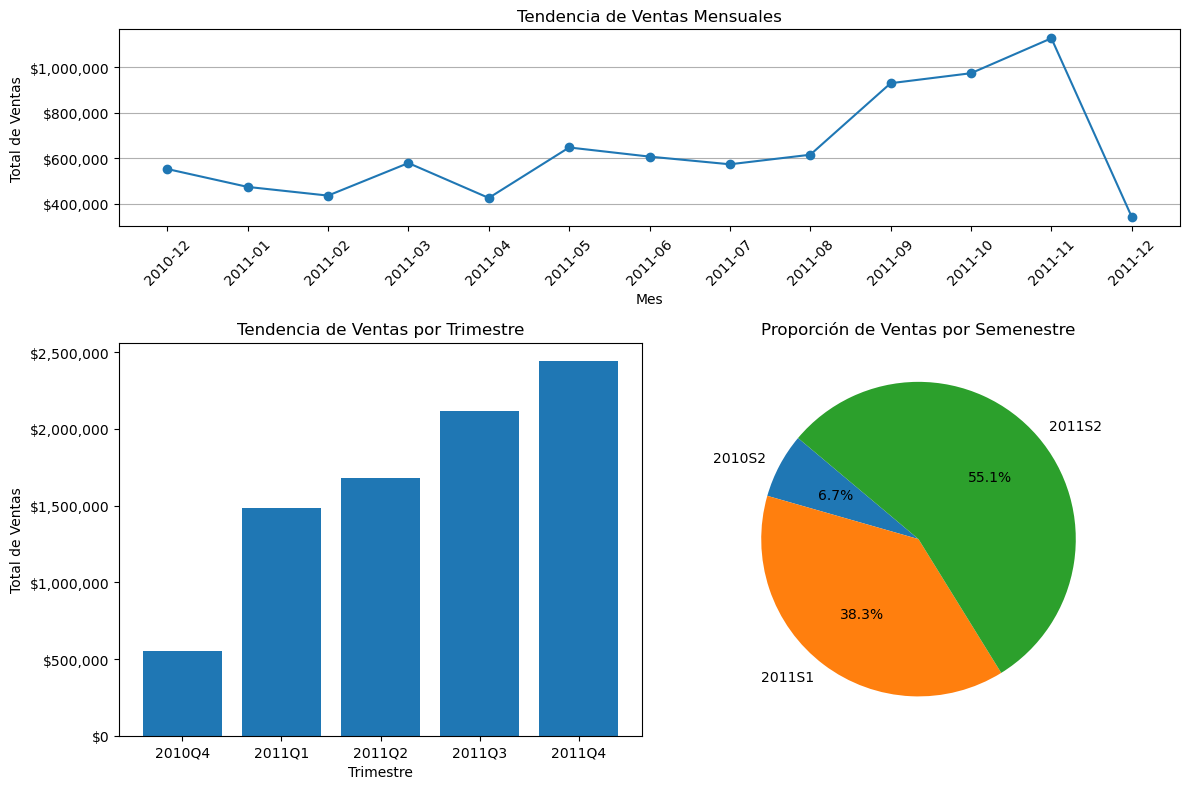

In [58]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,2], width_ratios=[1,1])
fig = plt.figure(figsize=(12,8))

# Serie de tiempo, análisis de ventas
ax1 = fig.add_subplot(gs[0, :]) # [0, :] -> [Primera fila, Totdas las columnas]
ax1.plot(
  monthly_sales["Month"].astype(str),
  monthly_sales["TotalAmount"],
  marker="o"
)
ax1.set_title("Tendencia de Ventas Mensuales")
ax1.set_xlabel("Mes")
ax1.set_ylabel("Total de Ventas")

plt.gca().yaxis.set_major_formatter(money_formatter)
plt.grid(True, axis="y")
plt.xticks(rotation=45)



ax2 = fig.add_subplot(gs[1, 0]) # [1, 0] -> [Segunda fila, Primer columna
ax2.bar(
  quarter_sales["Quaerter"].astype(str),
  quarter_sales["TotalAmount"]
)
ax2.set_title("Tendencia de Ventas por Trimestre")
ax2.set_xlabel("Trimestre")
ax2.set_ylabel("Total de Ventas")
plt.gca().yaxis.set_major_formatter(money_formatter)


ax3 = fig.add_subplot(gs[1, 1]) # [1, 1] -> [Segunda fila, Segunda columna]
ax3.pie(
  x=semester_sales,
  labels=semester_sales.index,
  autopct="%1.1f%%",
  startangle=140
)
ax3.set_title("Proporción de Ventas por Semenestre")

plt.tight_layout();

In [63]:
last_invoice = retail_cleaned["InvoiceDate"].max()
print(f"Última compra registrada: {last_invoice}")

Última compra registrada: 2011-12-09 12:50:00


**Observaciones**: La tendencia de ventas va en aumento a lo largo del 2011, sin embargo en Diciembre de ese año se puede apreciar una "caída" de las ventas, esto se debe a que solo contamos con 9 días de ventas registradas en dicho mes; a pesar de no contar con información del año completo, es posible apreciar que las ventas fueron significativamente altas especialmente a partir del mes de Agosto.